<a href="https://colab.research.google.com/github/andreaeusebi/pytorch_for_deep_learning/blob/main/notebooks/01_pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Fundamentals

In [ ]:
import torch
from torch import nn # nn contains all pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check pytorch version
print(torch.__version__)

2.1.0+cu121


## 1. Data preparing and loading

We'll use linear regression to make a straight line with known **parameters**.

In [ ]:
# create *known* parameters
weight = 0.7
bias = 0.3

# create some data
start = 0
end = 1
step = 0.02

z = torch.arange(start, end, step)
print(f"z[:5]:\n{z[:5]}\nz.shape: {z.shape}\nz.ndim: {z.ndim}")
print("-------------------------------------")

X = torch.arange(start, end, step).unsqueeze(dim=1) # add a dimension of size 1 along "columns", the first dimension
print(f"X[:5]:\n{X[:5]}\nX.shape: {X.shape}\nX.ndim: {X.ndim}")
print("-------------------------------------")

y = weight * X + bias
print(f"y[:5]:\n{y[:5]}\ny.shape: {y.shape}\ny.ndim: {y.ndim}")
print("-------------------------------------")

z[:5]:
tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800])
z.shape: torch.Size([50])
z.ndim: 1
-------------------------------------
X[:5]:
tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
X.shape: torch.Size([50, 1])
X.ndim: 2
-------------------------------------
y[:5]:
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])
y.shape: torch.Size([50, 1])
y.ndim: 2
-------------------------------------


Splitting data into training and test sets

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
train_split

40

In [ ]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [ ]:
len(X_train), len(X_test), X_train.shape, X_test.shape

(40, 10, torch.Size([40, 1]), torch.Size([10, 1]))

Add data visualization

In [ ]:
def plot_predicition(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend()

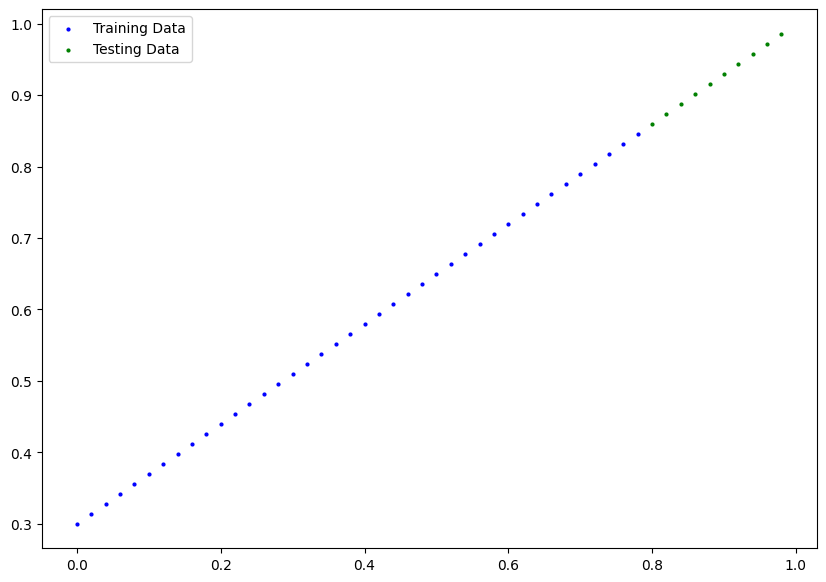

In [ ]:
plot_predicition()

## 2. Build model

What our model does:
* start with random values (weight & bias)
* look at training data and adjust parameters values to better represent the ideal values

How does it do so?
Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [ ]:
torch.manual_seed(42)

# Createa an istance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions

In [ ]:
with torch.inference_mode(): #inference_mode turns off gradient tracking
  y_preds = model_0(X_test) # calls forward() method

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

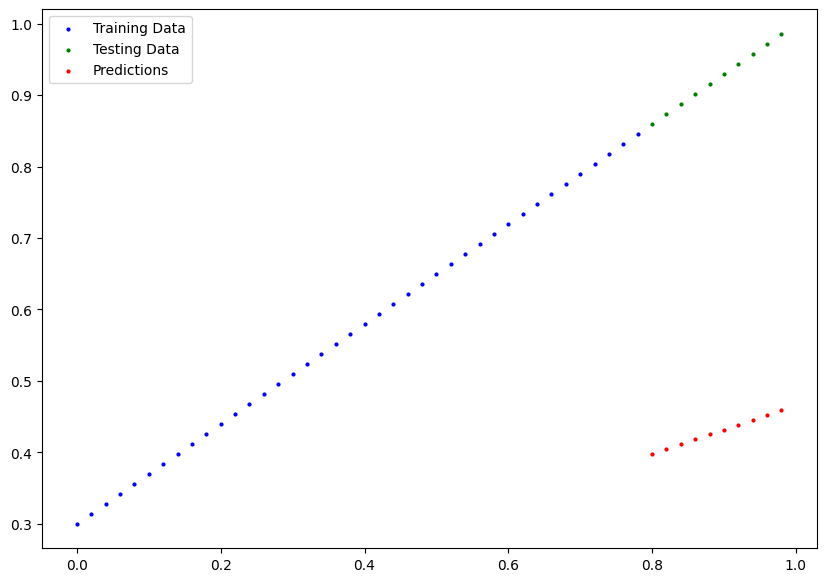

In [ ]:
plot_predicition(predictions=y_preds)

## 3. Train model

One way to measure how wrong your model predictions are is to use a Cost or Loss function.
Other name for cost function: Criterion

Things we need to train:
* A Loss function
* An optimizer (takes into account the Loss and adjust the model parameters)

Goal: minimize the Cost/Loss function.

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #lr = learning rate

### Building a training loop in PyTorch

In [ ]:
torch.manual_seed(42)

print("True values: ", weight, bias)

# An epoch is one loop through the data
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

print(model_0.state_dict())

### TRAINING ###

# 0. Loop throught the data
for epoch in range(epochs):
  # print("epoch: ", epoch)

  # Set the model to training mode
  model_0.train() # set all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss/cost
  loss = loss_fn(y_pred, y_train)

  # print("loss: ", loss.item())

  # 3. Optimizer zero grad (set gradient to zero)
  optimizer.zero_grad()

  # 4. Perform back propagation on the loss with respect to the parameters of the model (calculate the gradient of each parameter)
  loss.backward()

  # 5. Step the optimizer (perform gradient descent based on the gradient computed from loss.backward())
  optimizer.step()

  # print(model_0.state_dict())

  ### TESTING ###
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing

  with torch.inference_mode(): # turns off gradient tracking
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss on test data
    test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss} | Params: {model_0.state_dict()}")

      # Record data
      epoch_count.append(epoch)
      loss_values.append(loss.item())
      test_loss_values.append(test_loss.item())



True values:  0.7 0.3
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495 | Params: OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428 | Params: OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688 | Params: OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703 | Params: OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106 | Params: OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024 | Params: OrderedDict([('weights', tensor([0.4938])), ('bias', ten

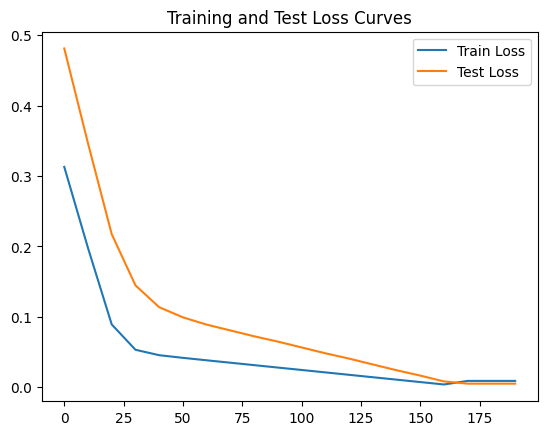

In [ ]:
# Plot loss curves
plt.plot(epoch_count, loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

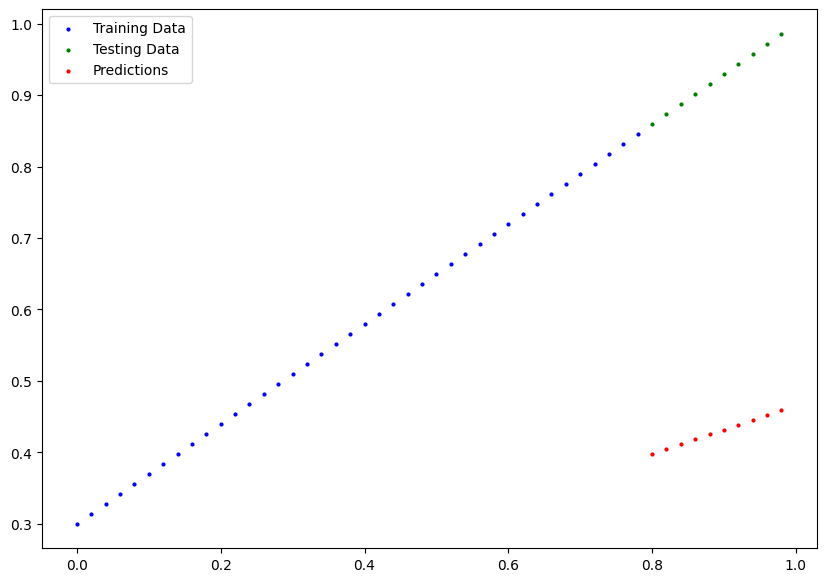

In [ ]:
plot_predicition(predictions=y_preds)

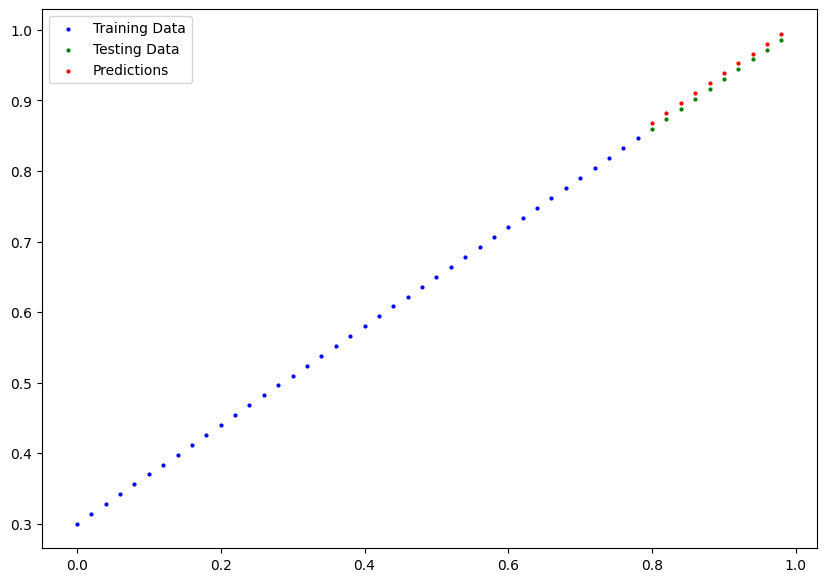

In [ ]:
plot_predicition(predictions=y_preds_new)

## Saving a model in PyTorch

There are three main methods for saving and loading models in PyTorch:
1. torch.save()
2. torch.load()
3. torch.nn.Module.load_state_dict() -> this allows to load a model parameters dictionary (is simply a Python dictionary) --> THIS IS ALSO THE RECOMMENDED WAY

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Saving our pytorch model
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(MODEL_SAVE_PATH)

# 3. Save the state dict (recommended way)
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)


models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Feb  2 10:39 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

In [ ]:
# Instantiate a new model class
loaded_model_0 = LinearRegressionModel()

print(loaded_model_0.state_dict())

# Load the save state_dict() of model_0
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

print(loaded_model_0.state_dict())

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])


In [ ]:
# Make some predictions to check the loaded module
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together